## Introduction & Data Context

## 🏥 Medical Background: Understanding Leukemia

**Leukemia** is a broad term for cancers of the blood-forming tissues, including the bone marrow and the lymphatic system. It usually involves the white blood cells (WBCs). In a healthy body, WBCs are potent infection fighters; they grow and divide in an orderly way. In people with leukemia, the bone marrow produces an excessive amount of abnormal white blood cells, which don't function properly.

### Types of Leukemia

Leukemia is generally classified by two factors: **speed of progression** (Acute vs. Chronic) and the **type of cell involved** (Lymphocytic vs. Myelogenous).

| Classification | **Lymphocytic** (Lymphoid cells) | **Myelogenous** (Myeloid cells) |
| --- | --- | --- |
| **Acute** (Fast-growing) | **ALL** (Acute Lymphoblastic Leukemia) | **AML** (Acute Myeloid Leukemia) |
| **Chronic** (Slow-growing) | **CLL** (Chronic Lymphocytic Leukemia) | **CML** (Chronic Myeloid Leukemia) |

### 🎯 Project Scope: Acute Lymphoblastic Leukemia (ALL)

This EDA focuses specifically on **ALL**.
ALL is the most common type of cancer in children. It occurs when the bone marrow produces too many immature lymphocytes (called **lymphoblasts**).

The diagnostic challenge lies in distinguishing these malignant **lymphoblasts** from healthy, normal **lymphocytes**.

---

## 💾 The Dataset: C-NMC (Leukemia Challenge)

We are using the **C-NMC (Classification of Normal vs. Malignant Cells)** dataset, originally published for the ISBI 2019 challenge.

* **Nature:** Single-cell microscopic images extracted from blood smears.
* **Preprocessing:** Cells are already segmented (background removed or cropped) and centered.
* **The Task:** Binary Classification.

### Class Definitions

1. **ALL (Malignant):** Cells identified as lymphoblasts (cancerous).
2. **HEM (Normal):** Cells identified as healthy lymphocytes (non-cancerous).

> **Note:** The dataset does not strictly include other WBC types (like neutrophils or monocytes) which are visually distinct. It focuses on the "hardest negative": distinguishing a healthy lymphocyte from a cancerous lymphoblast.

---

## 🔍 Objectives of this EDA (Exploratory Data Analysis)

Before feeding data into Deep Learning models, we must understand its properties to avoid "Garbage In, Garbage Out."

1. **Class Balance:** Determine if we have significantly more Cancer images than Normal images (imbalance requires specific loss functions like *Focal Loss*).
2. **Image Dimensions:** Analyze the distribution of image heights/widths to determine the optimal resizing strategy for the neural network (e.g.,  vs ).
3. **Color Consistency:** Check for variations in staining (color intensity). Significant differences between labs/batches might require stain normalization.
4. **Data Quality:** Identify potential artifacts, outliers, or duplicate images that could lead to data leakage.
5. **Visual "Human Baseline":** Visualize random samples to gauge the difficulty of the task for a human observer.


## 1. Dataset

In [1]:
!pip -q install kagglehub[pandas-datasets]

In [2]:
# Import
import numpy as np
import pandas as pd
import kagglehub
import os
import tqdm
import cv2

from glob import glob
from matplotlib import pyplot as plt
from PIL import Image

In [3]:


print("📥 Téléchargement du dataset...")
dataset_path = kagglehub.dataset_download("shafiullahshafin/c-nmc-2019-dataset")

print(f"✅ Dataset téléchargé ici : {dataset_path}")

def build_dataframe(base_path):
    data = []
    image_paths = glob(os.path.join(base_path, '**', '*.bmp'), recursive=True)

    print(f"🔍 Images trouvées : {len(image_paths)}")

    for img_path in image_paths:
        folder_name = os.path.basename(os.path.dirname(img_path))

        # Normalisation des labels
        if 'all' in folder_name.lower():
            label = 'ALL' # Leucémie
        elif 'hem' in folder_name.lower():
            label = 'HEM' # Normal
        else:
            continue # On ignore les fichiers qui ne sont pas dans les bons dossiers

        data.append({
            'image_path': img_path,
            'label': label,
            'filename': os.path.basename(img_path)
        })

    return pd.DataFrame(data)

# 3. Création et affichage
df = build_dataframe(dataset_path)

print(f"\n📊 DataFrame construit avec {len(df)} images.")
print(df.head())

📥 Téléchargement du dataset...
Using Colab cache for faster access to the 'c-nmc-2019-dataset' dataset.
✅ Dataset téléchargé ici : /kaggle/input/c-nmc-2019-dataset
🔍 Images trouvées : 15114

📊 DataFrame construit avec 10661 images.
                                          image_path label  \
0  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
1  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
2  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
3  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
4  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   

              filename  
0   UID_28_5_3_all.bmp  
1  UID_45_24_5_all.bmp  
2   UID_45_7_1_all.bmp  
3  UID_52_10_5_all.bmp  
4  UID_52_21_7_all.bmp  


In [4]:
df

,image_path,label,filename
0,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,ALL,UID_28_5_3_all.bmp
1,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,ALL,UID_45_24_5_all.bmp
2,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,ALL,UID_45_7_1_all.bmp
3,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,ALL,UID_52_10_5_all.bmp
4,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,ALL,UID_52_21_7_all.bmp
...,...,...,...
10656,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,HEM,UID_H23_19_8_hem.bmp
10657,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,HEM,UID_H48_10_3_hem.bmp
10658,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,HEM,UID_H2_33_2_hem.bmp
10659,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,HEM,UID_H2_38_3_hem.bmp


Text(0.5, 1.0, 'Répartition des classes')

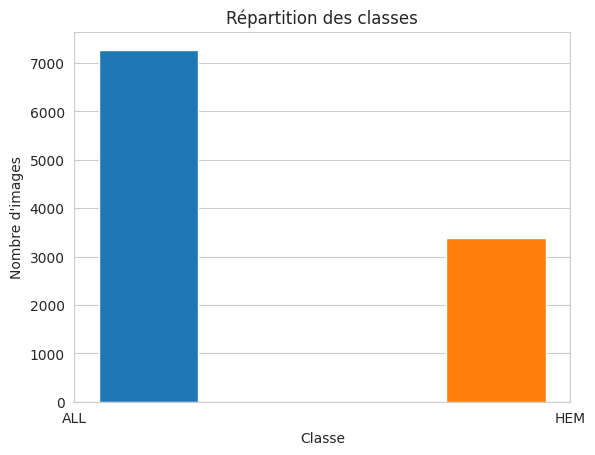

In [22]:
df_all = df[df['label'] == 'ALL'].copy().reset_index(drop=True)
df_hem = df[df['label'] == 'HEM'].copy().reset_index(drop=True)

plt.hist([df_all['label'], df_hem['label']], bins=2)
plt.xticks(ticks=[0, 1], labels=['ALL', 'HEM'])
plt.xlabel('Classe')
plt.ylabel('Nombre d\'images')
plt.title('Répartition des classes')

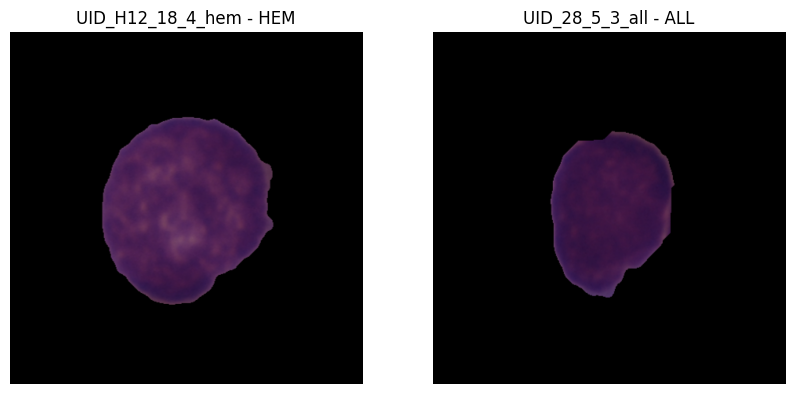

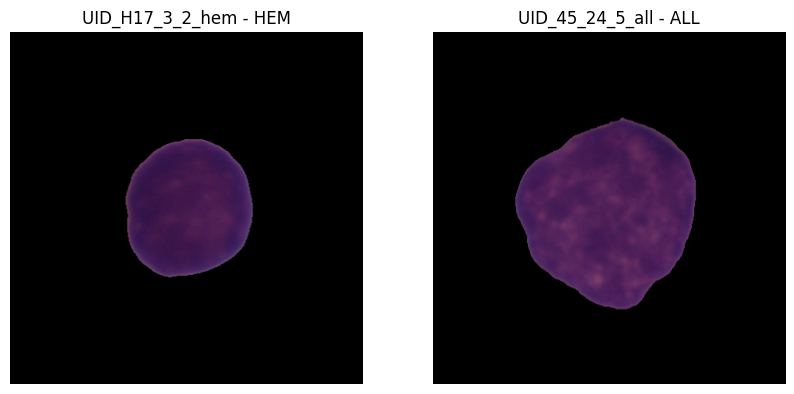

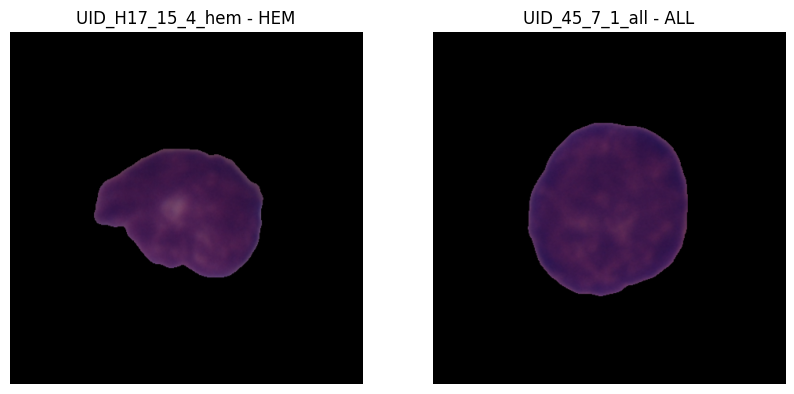

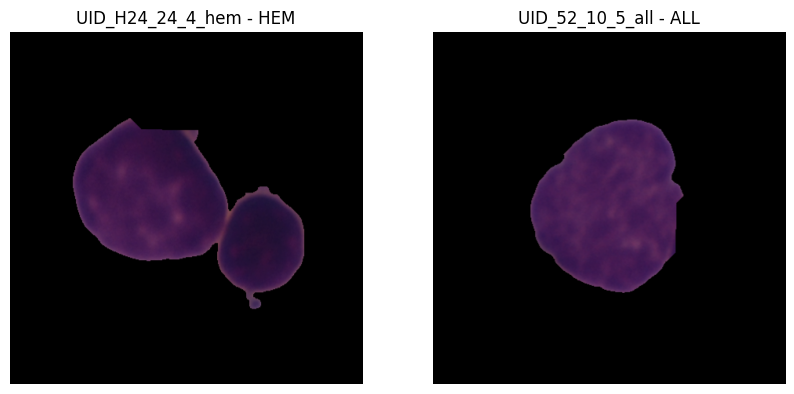

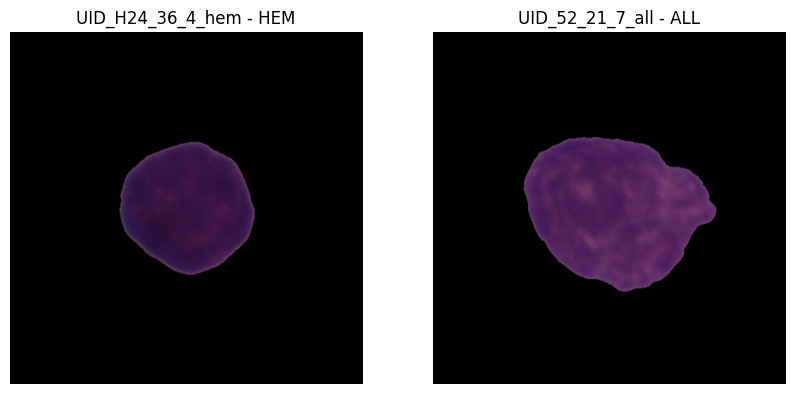

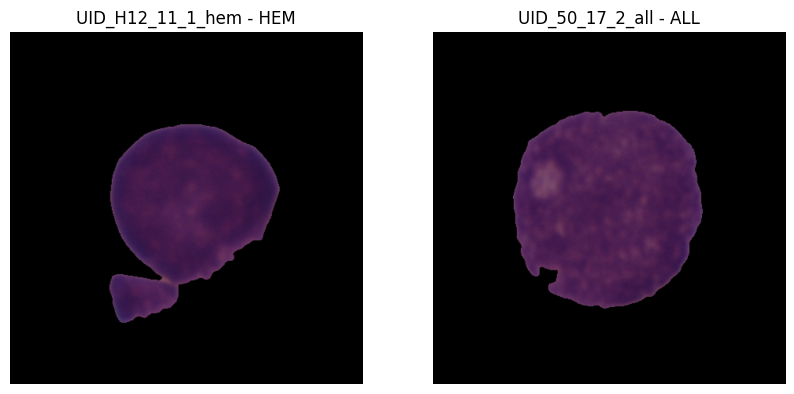

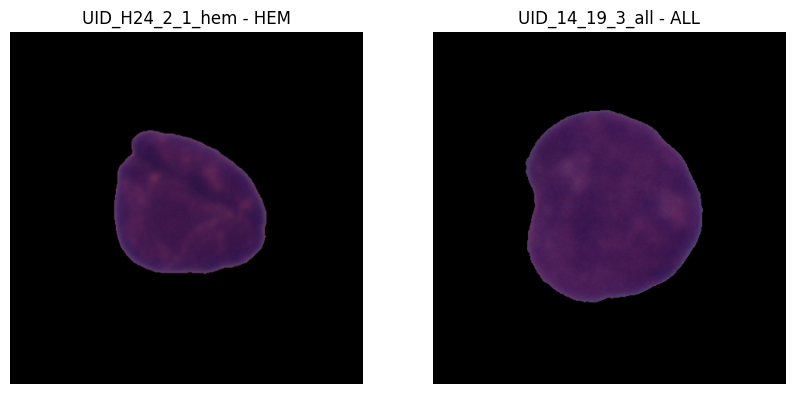

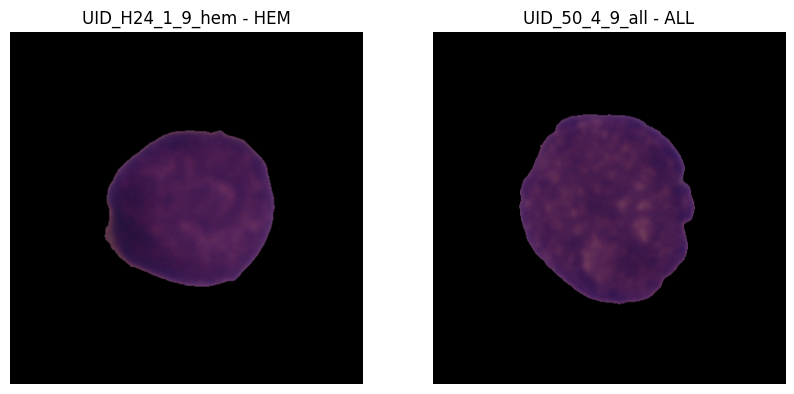

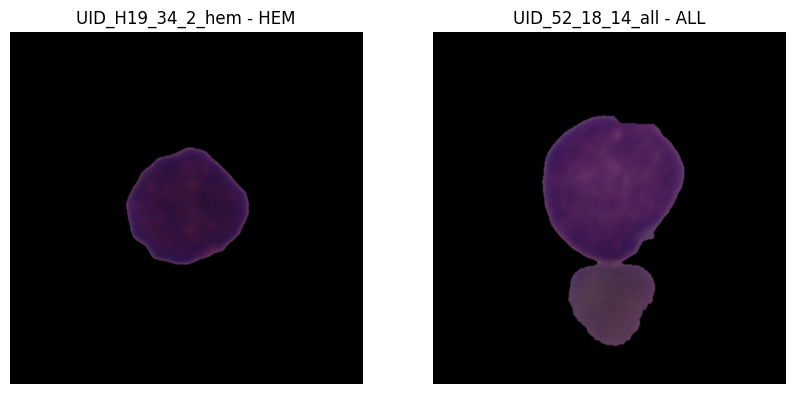

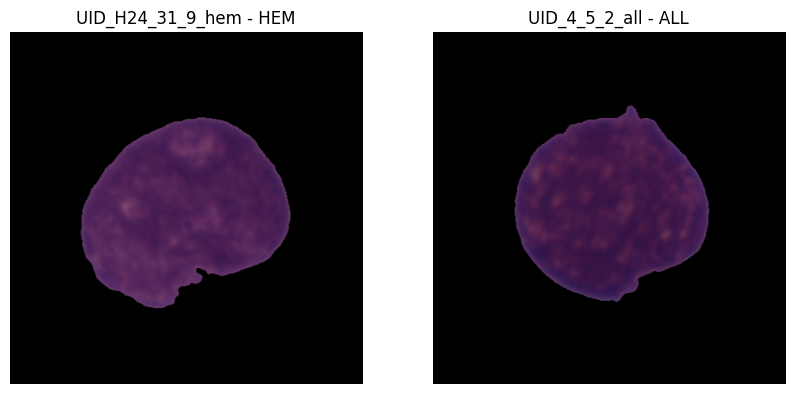

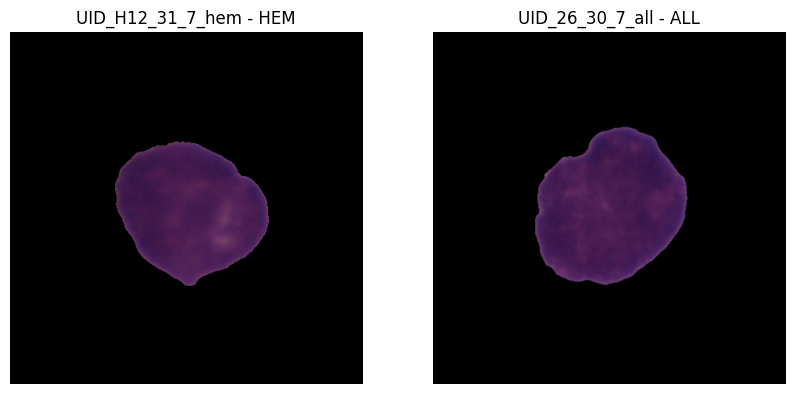

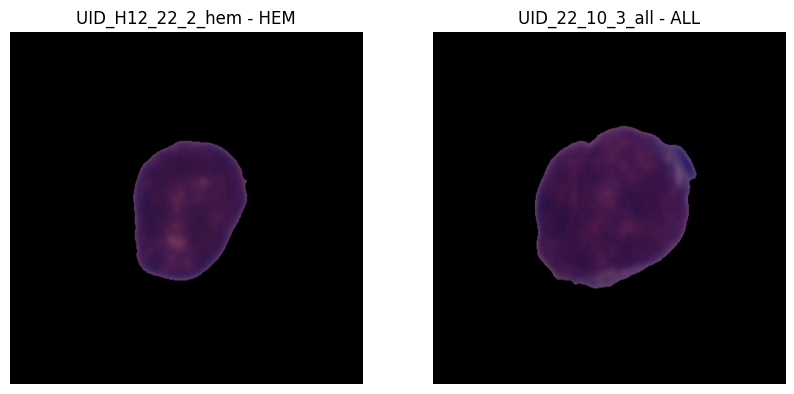

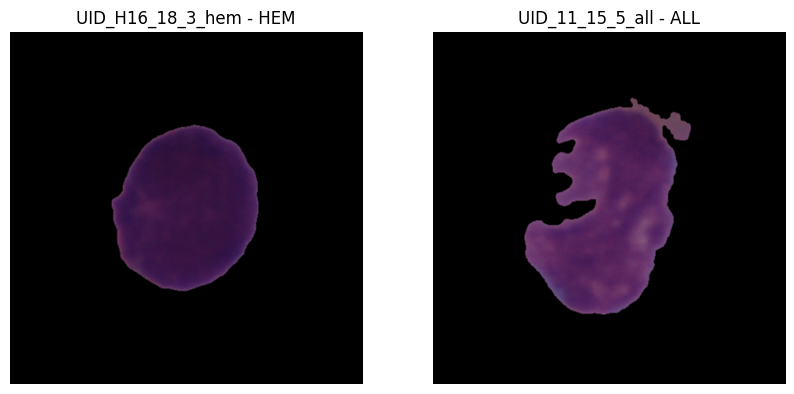

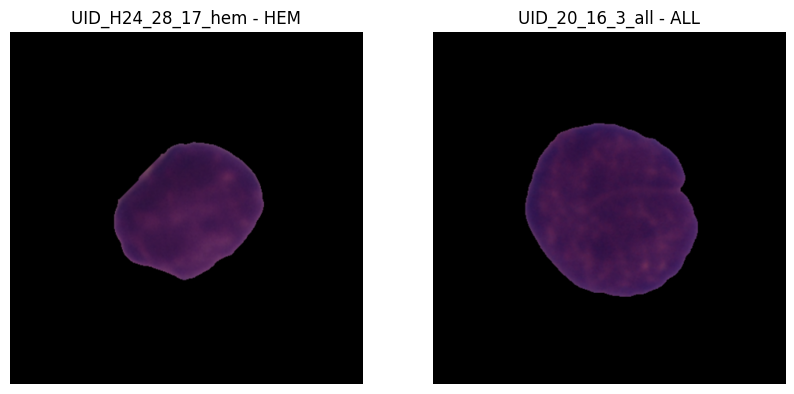

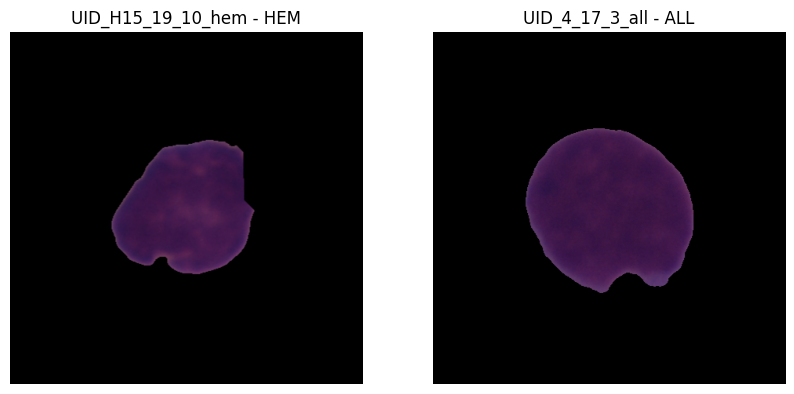

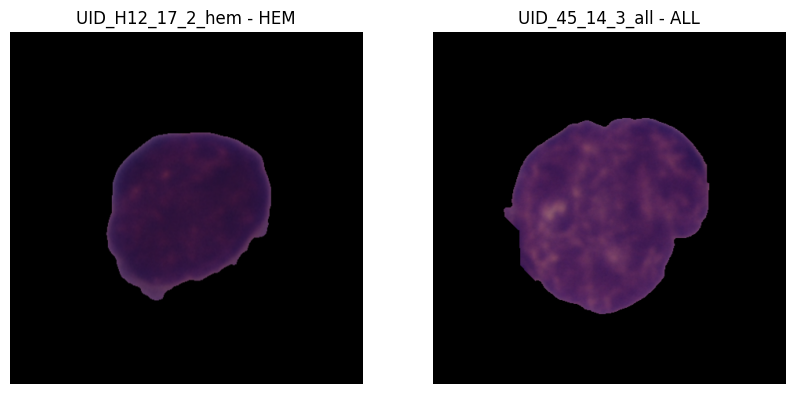

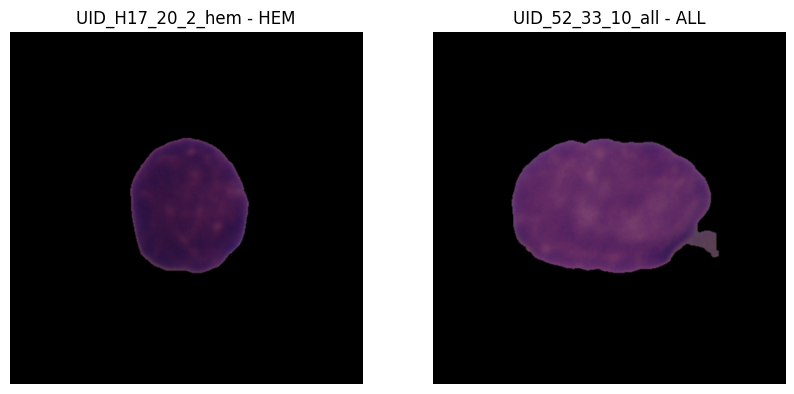

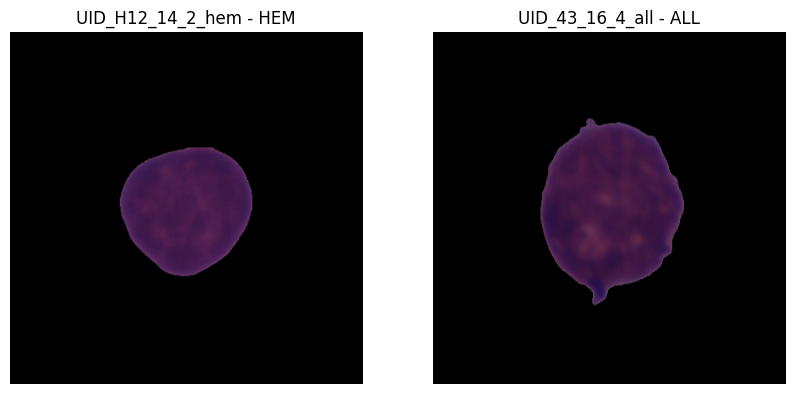

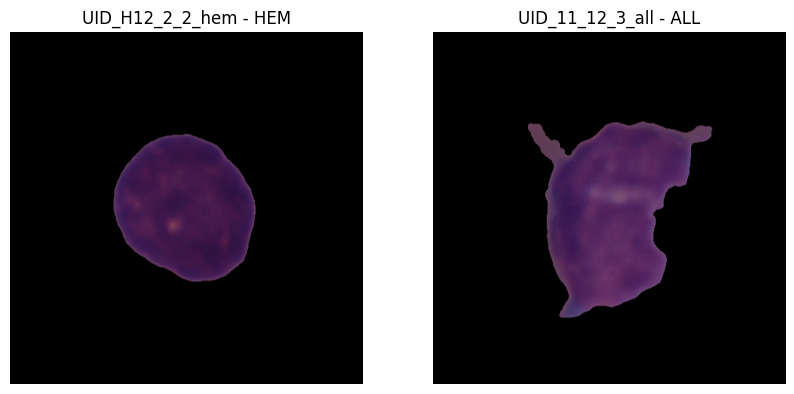

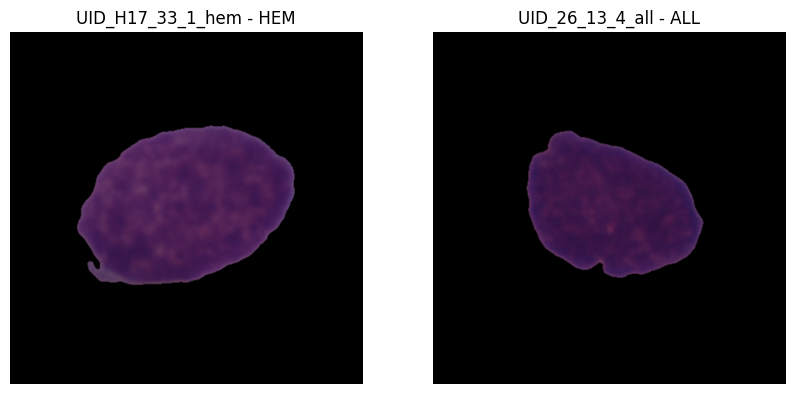

In [6]:
def get_img_info(df, num):
    image_path = df.iloc[num]['image_path']
    image = Image.open(image_path)
    image_classe = df.iloc[num]['label']
    image_title = f"{df.iloc[num]['filename'].split(".")[0]} - {image_classe}"

    return image, image_title

for i in range(20):
    hem_image, hem_image_title = get_img_info(df_hem, i)
    all_image, all_image_title = get_img_info(df_all, i)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(hem_image)
    axs[0].set_title(hem_image_title)
    axs[0].axis('off')
    axs[1].imshow(all_image)
    axs[1].set_title(all_image_title)
    axs[1].axis('off')
    plt.show()

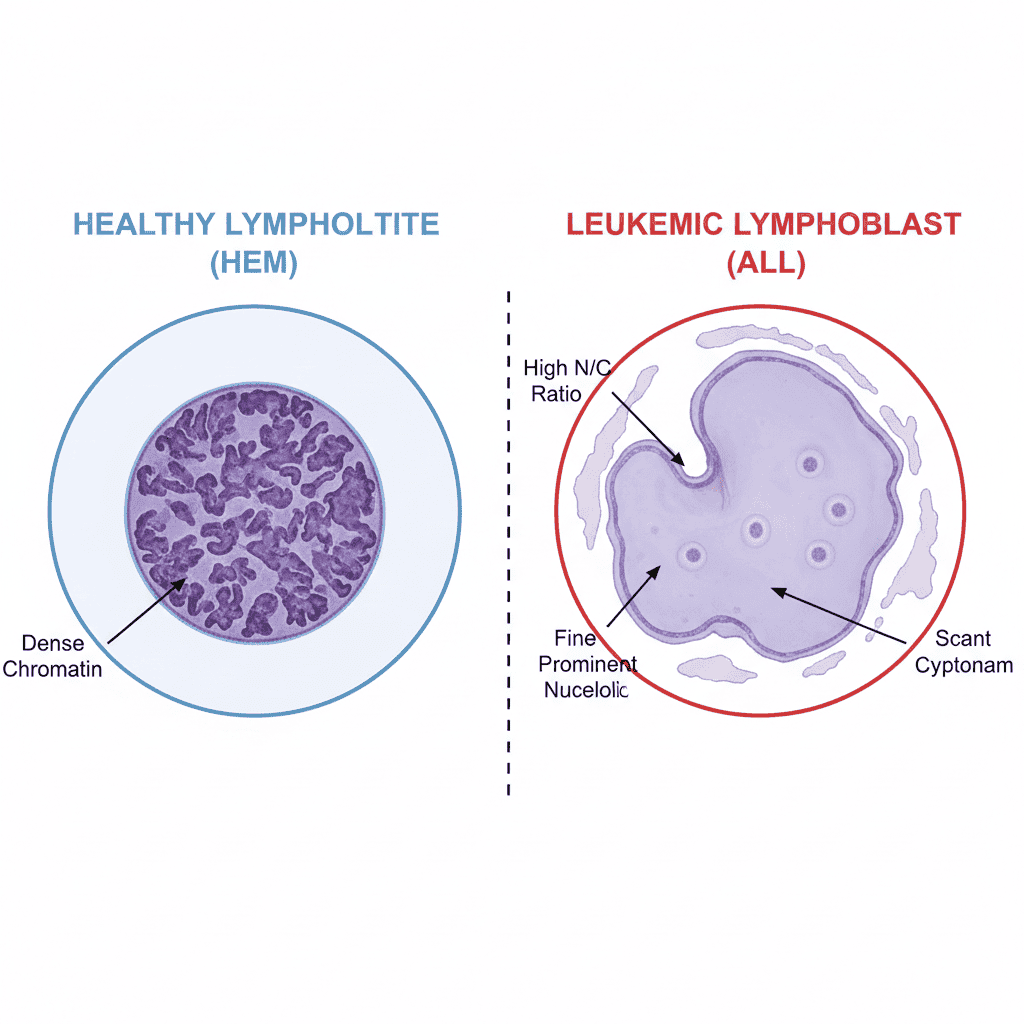


### Cellular Architecture in Computer Vision

The **lymphocyte** 🧫 is a type of white blood cell with a relatively simple structure. It consists of a central **nucleus** 🧠 (containing the DNA), a surrounding **cytoplasm** (the cell's machinery), and an outer **membrane**. In medical datasets, images are typically "cropped" to focus on the nucleus, often leaving only a thin rim of visible cytoplasm.

### From Patient to Pixel: The Staining Process

Digital images are the result of a precise laboratory workflow known as the **May-Grünwald Giemsa (MGG)** staining technique. After a blood smear is fixed with methanol, chemical dyes react based on pH levels:

* **Eosin** (acidic) binds to basic components, turning the cytoplasm pale pink or blue.
* **Methylene Blue** (basic) binds to acidic components like DNA, staining the nucleus a deep purple.

Crucially, **chromatin** is not a substance added to the cell; it is the DNA itself. Its visual appearance reflects the cell's state: in healthy cells, it is tightly coiled and appears dark and "clumpy," whereas in active leukemic cells, it uncoils to be read, appearing lighter and smoother. 🔬

### Clinical Diagnostic Layers

Hematologists use a multi-tiered approach to identify **Acute Lymphoblastic Leukemia (ALL)**. The first stage is **Morphological Examination**, which mirrors what a computer vision model attempts to do. Experts look for a high **N/C ratio** (where the nucleus occupies over 90% of the cell), increased size, and the presence of **nucleoli** (pale "holes" in the nucleus).

The definitive "Gold Standard," however, is **Immunophenotyping**. This process uses flow cytometry to detect specific protein markers (like CD34 or TdT) on the cell surface. While ALL appears abruptly in a patient, it is often detected at a stage where billions of malignant cells are already present, making rapid screening vital. 🏥


## 2. Staining Analysis

This analysis examines the distribution of RGB channels and global pixel intensity across both healthy (HEM) and leukemic (ALL) classes.

Since blood smears are processed using chemical stains like MGG, colors can vary significantly between laboratories. If one class appears consistently "more purple" or "brighter" due to lab conditions rather than biology, the model will develop a "staining bias". Quantifying this ensures you can implement Stain Normalization to make the model focus on pathology rather than laboratory artifacts.

In [8]:
class StainingAnalyzer:
    def __init__(self):
        pass

    def _load_image_bgr(self, image_path):
        """Charge l'image en BGR (standard OpenCV)."""
        return cv2.imread(image_path)

    def get_rgb_stats(self, image_path):
        """Calcule la moyenne et l'écart-type pour R, G, B."""
        image = self._load_image_bgr(image_path)
        if image is None: return None

        mean_b, mean_g, mean_r = np.mean(image, axis=(0, 1))
        std_b, std_g, std_r = np.std(image, axis=(0, 1))

        return {
            'mean_r': mean_r, 'mean_g': mean_g, 'mean_b': mean_b,
            'std_r': std_r, 'std_g': std_g, 'std_b': std_b
        }

    def get_hsv_stats(self, image_path):
        """Calcule la moyenne et l'écart-type pour H, S, V."""
        image_bgr = self._load_image_bgr(image_path)
        if image_bgr is None: return None

        image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

        mean_h, mean_s, mean_v = np.mean(image_hsv, axis=(0, 1))
        std_h, std_s, std_v = np.std(image_hsv, axis=(0, 1))

        return {
            'mean_h': mean_h, 'mean_s': mean_s, 'mean_v': mean_v,
            'std_h': std_h, 'std_s': std_s, 'std_v': std_v
        }

    def get_all_stats(self, image_path):
        image_bgr = cv2.imread(image_path)
        if image_bgr is None: return None

        image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

        mask = image_bgr.max(axis=2) > 0
        pixels_bgr = image_bgr[mask]
        pixels_hsv = image_hsv[mask]

        res = {}

        b_mean, g_mean, r_mean = pixels_bgr.mean(axis=0)
        b_std, g_std, r_std = pixels_bgr.std(axis=0)

        h_mean, s_mean, v_mean = pixels_hsv.mean(axis=0)
        h_std, s_std, v_std = pixels_hsv.std(axis=0)

        return {
            'mean_r': r_mean, 'mean_g': g_mean, 'mean_b': b_mean,
            'std_r': r_std, 'std_g': g_std, 'std_b': b_std,
            'mean_h': h_mean, 'mean_s': s_mean, 'mean_v': v_mean,
            'std_h': h_std, 'std_s': s_std, 'std_v': v_std
        }





### 🧬 Summary: HSV in Hematology Analysis

In medical computer vision, raw RGB pixels often hide the truth. By converting to **HSV (Hue, Saturation, Value)**, we can isolate two distinct signals:

#### 1. Hue (): The Technical "Recipe"

**Hue** represents the pure color (the shade of purple/violet). In hematology, this is a **chemical signature** rather than a biological one.

* **The Cause**: It is determined by the **MGG (May-Grünwald Giemsa) staining process**.
* **The Bias**: Variations in Hue are usually caused by lab-specific factors: the brand of the dye, the pH of the water, or the exact duration the slide was soaked.
* **The Rule**: If the Hue differs significantly between classes, your model might learn to recognize a specific lab's "recipe" instead of the cancer itself.

#### 2. Value & Saturation: The Biological "Architecture"

These two parameters measure how much dye was absorbed and how it is distributed. This is a **structural signature** of the cell's DNA.

* **The Chromatin Factor**: Think of DNA (**chromatin**) as a sponge.
* **Healthy Cells (HEM)**: The DNA is tightly packed (**condensed**). This "dense sponge" absorbs a high concentration of dye, resulting in **lower Value** (darker) and **higher Saturation** (vivid color).
* **Leukemic Cells (ALL)**: The DNA is loose and spread out (**fine chromatin**). This "loose sponge" retains less dye, resulting in **higher Value** (brighter) and **lower Saturation** (faded color).

---

### 📊 Quick Reference Table

| Parameter | Meaning | Source | Clinical Significance |
| --- | --- | --- | --- |
| **Hue (H)** | Pure Color (Violet/Pink) | **Lab Technique** | Potential bias; must be normalized. |
| **Saturation (S)** | Color Intensity | **Biology** | Indicates how much dye the DNA absorbed. |
| **Value (V)** | Brightness | **Biology** | Key marker of **Chromatin Density**. |


In [23]:
stain_analyser = StainingAnalyzer()
results = []

for path in tqdm.tqdm(df_hem['image_path']):
    stats = stain_analyser.get_all_stats(path)
    results.append(stats)

df_stats = pd.DataFrame(results)
df_hem = pd.concat([df_hem, df_stats], axis=1)

100%|██████████| 3389/3389 [01:09<00:00, 48.78it/s]


In [10]:
df_hem.head(5)

,image_path,label,filename,mean_r,mean_g,mean_b,std_r,std_g,std_b,mean_h,mean_s,mean_v,std_h,std_s,std_v
2397,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,HEM,UID_H12_18_4_hem.bmp,61.525430,25.847047,71.097198,13.024258,9.693146,11.890391,143.960981,164.080369,71.336861,4.347083,20.603905,12.106134
2398,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,HEM,UID_H17_3_2_hem.bmp,72.852851,29.512699,81.786380,9.944641,8.459708,8.194313,144.994730,164.172765,81.884307,2.572138,17.917007,8.290583
2399,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,HEM,UID_H17_15_4_hem.bmp,56.370485,25.488226,70.542124,11.768359,8.665500,12.025743,140.944711,163.988458,70.713299,4.194722,19.254035,12.053942
2400,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,HEM,UID_H24_24_4_hem.bmp,58.760937,24.478662,71.520801,10.747918,9.516132,10.879088,142.181348,169.112256,71.606445,3.626498,22.007049,10.932387
2401,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,HEM,UID_H24_36_4_hem.bmp,65.957295,28.490492,74.465342,11.982463,7.957756,11.475296,144.662013,158.229035,74.511932,3.551981,15.520364,11.509578


In [24]:
stain_analyser = StainingAnalyzer()
results = []

for path in tqdm.tqdm(df_all['image_path']):
    stats = stain_analyser.get_all_stats(path)
    results.append(stats)

df_stats = pd.DataFrame(results)
df_all = pd.concat([df_all, df_stats], axis=1)

df_all.head(5)

100%|██████████| 7272/7272 [02:40<00:00, 45.27it/s]


,image_path,label,filename,mean_r,mean_g,mean_b,std_r,std_g,std_b,mean_h,mean_s,mean_v,std_h,std_s,std_v
0,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,ALL,UID_28_5_3_all.bmp,60.325552,23.679605,70.719324,10.181975,7.233987,9.538632,143.705232,170.425422,70.985238,4.249829,17.438778,9.654190
1,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,ALL,UID_45_24_5_all.bmp,79.218725,33.805114,89.245809,11.760609,6.794706,9.490685,144.714443,158.698290,89.463070,3.610894,13.970191,9.649368
2,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,ALL,UID_45_7_1_all.bmp,65.538502,27.494805,79.683094,10.380077,6.777365,8.952264,142.107006,167.283710,79.752236,3.724780,15.708976,8.978128
3,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,ALL,UID_52_10_5_all.bmp,74.323154,32.048095,86.386907,10.234160,6.584930,8.845835,143.524779,160.411624,86.449135,2.978168,15.155084,8.837860
4,/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...,ALL,UID_52_21_7_all.bmp,86.613003,38.522537,94.512363,12.154756,8.117144,10.090744,145.890026,151.774254,94.799675,2.937787,14.686576,10.340319


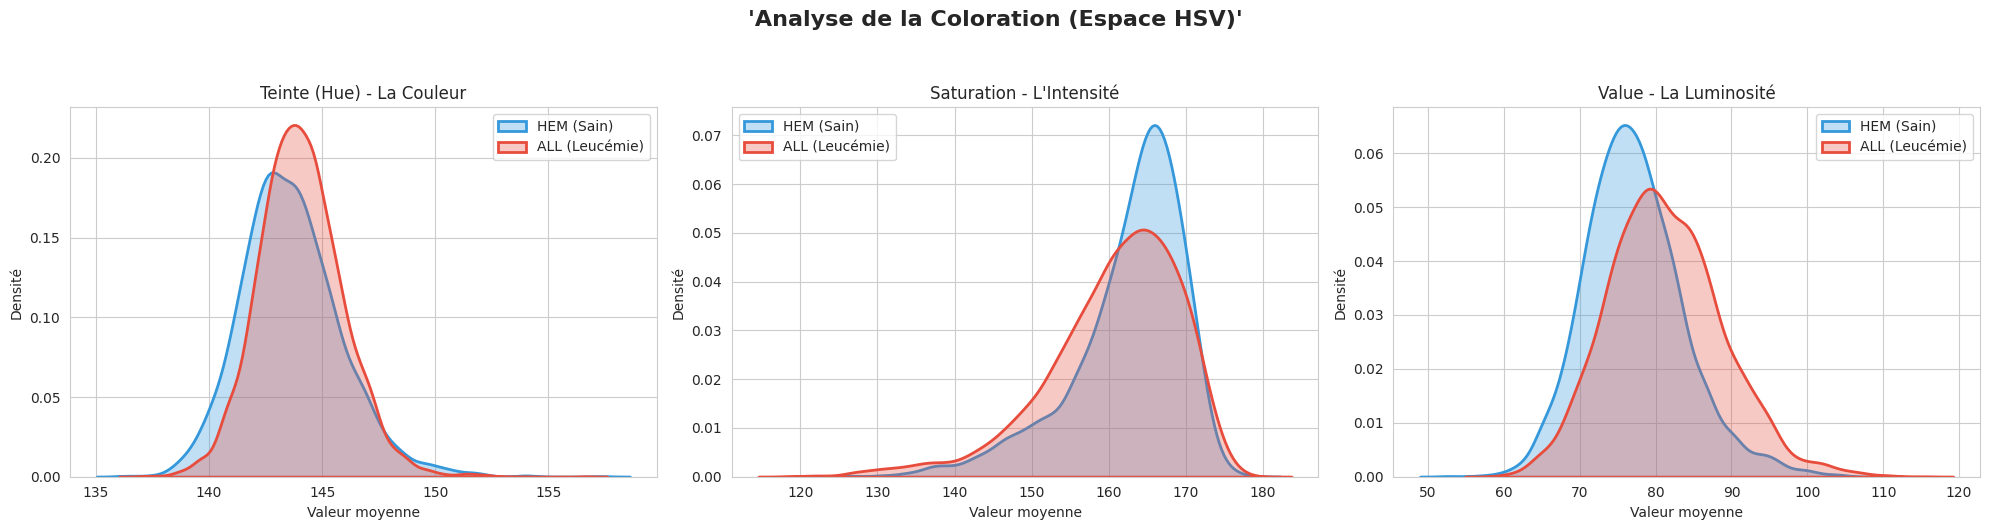

In [27]:
import seaborn as sns

def plot_hsv(df_hem, df_all, metrics, title, suptitle):
    sns.set_style("whitegrid")
    color_hem = '#3498db'
    color_all = '#e74c3c'

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(suptitle, fontsize=16, fontweight='bold', y=1.05)

    for i, col in enumerate(metrics):
        ax = axes[i]
        if col in df_hem.columns:
            sns.kdeplot(
                data=df_hem,
                x=col,
                color=color_hem,
                label='HEM (Sain)',
                fill=True,
                alpha=0.3,
                linewidth=2,
                ax=ax
            )

        if col in df_all.columns:
            sns.kdeplot(
                data=df_all,
                x=col,
                color=color_all,
                label='ALL (Leucémie)',
                fill=True,
                alpha=0.3,
                linewidth=2,
                ax=ax
            )

        ax.set_title(titles[i])
        ax.set_xlabel("Valeur moyenne")
        ax.set_ylabel("Densité")
        ax.legend()

    plt.tight_layout()
    plt.show()

metrics = ['mean_h', 'mean_s', 'mean_v']
titles = ['Teinte (Hue) - La Couleur', 'Saturation - L\'Intensité', 'Value - La Luminosité']
suptitle = "'Analyse de la Coloration (Espace HSV)'"
plot_hsv(df_hem, df_all, metrics, titles, suptitle)

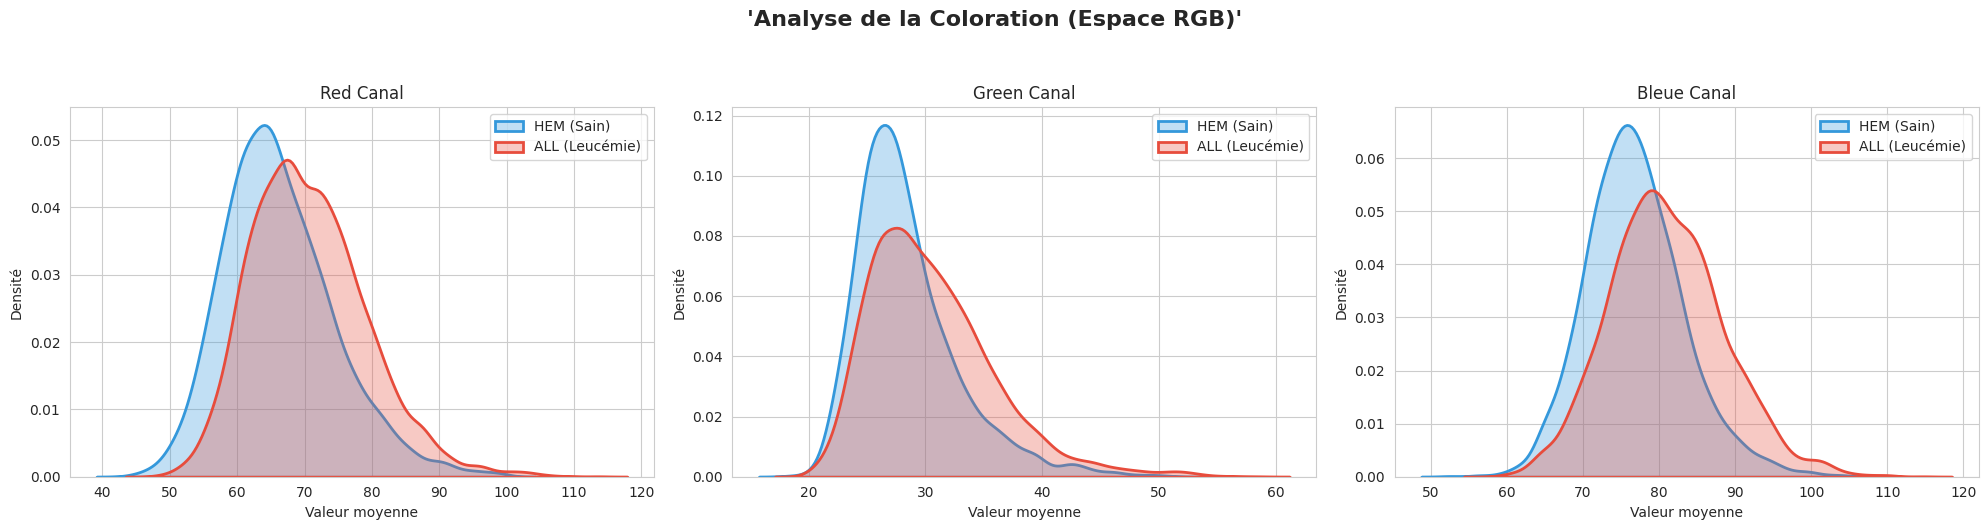

In [28]:
metrics = ['mean_r', 'mean_g', 'mean_b']
titles = ['Red Canal', 'Green Canal', 'Bleue Canal']
suptitle = "'Analyse de la Coloration (Espace RGB)'"
plot_hsv(df_hem, df_all, metrics, titles, suptitle)

In [29]:
def display_mean_comparison(df_hem, df_all):
    potential_cols = ['mean_h', 'mean_s', 'mean_v', 'mean_r', 'mean_g', 'mean_b']
    target_cols = [c for c in potential_cols if c in df_hem.columns]

    hem_stats = df_hem[target_cols].mean()
    all_stats = df_all[target_cols].mean()

    comparison_df = pd.DataFrame({
        'HEM (Sain)': hem_stats,
        'ALL (Malade)': all_stats
    })

    comparison_df['Différence'] = comparison_df['ALL (Malade)'] - comparison_df['HEM (Sain)']
    comparison_df['Variation (%)'] = (comparison_df['Différence'] / comparison_df['HEM (Sain)']) * 100
    print("--- 📊 RÉCAPITULATIF QUANTITATIF (Moyenne des Moyennes) ---")
    return comparison_df.round(2)

stats_summary = display_mean_comparison(df_hem, df_all)
display(stats_summary)

--- 📊 RÉCAPITULATIF QUANTITATIF (Moyenne des Moyennes) ---


,HEM (Sain),ALL (Malade),Différence,Variation (%)
mean_h,143.62,144.05,0.42,0.29
mean_s,162.50,160.59,-1.90,-1.17
mean_v,77.16,81.26,4.10,5.31
mean_r,66.23,70.64,4.42,6.67
mean_g,28.41,30.54,2.12,7.46
mean_b,76.80,80.95,4.15,5.40


In [30]:
from scipy import stats

def test_significance(df_hem, df_all, feature='mean_v'):
    group_hem = df_hem[feature].dropna()
    group_all = df_all[feature].dropna()

    t_stat, p_val = stats.ttest_ind(group_hem, group_all, equal_var=False)
    diff = group_hem.mean() - group_all.mean()
    pooled_std = np.sqrt((group_hem.std()**2 + group_all.std()**2) / 2)
    cohens_d = abs(diff / pooled_std)

    print(f"--- Analyse de Significativité pour '{feature}' ---")
    print(f"P-value : {p_val:.2e} ", end="")
    if p_val < 0.05:
        print("Statistiquement significatif")
    else:
        print("Non significatif")

    print(f"Cohen's d : {cohens_d:.3f}")

    if cohens_d < 0.2:
        print("Taille de l'effet : Négligeable")
    elif cohens_d < 0.5:
        print("Taille de l'effet : Petite")
    elif cohens_d < 0.8:
        print("Taille de l'effet : Moyenne")
    else:
        print("Taille de l'effet : Grande")

test_significance(df_hem, df_all, 'mean_h')
print("-" * 30)
test_significance(df_hem, df_all, 'mean_s')
print("-" * 30)
test_significance(df_hem, df_all, 'mean_v')


--- Analyse de Significativité pour 'mean_h' ---
P-value : 1.01e-21 Statistiquement significatif
Cohen's d : 0.206
Taille de l'effet : Petite
------------------------------
--- Analyse de Significativité pour 'mean_s' ---
P-value : 4.39e-31 Statistiquement significatif
Cohen's d : 0.235
Taille de l'effet : Petite
------------------------------
--- Analyse de Significativité pour 'mean_v' ---
P-value : 4.87e-170 Statistiquement significatif
Cohen's d : 0.577
Taille de l'effet : Moyenne


The quantitative and visual analysis of the C-NMC dataset's colorimetric properties provides a solid foundation for our modeling strategy. By decoupling the chemical staining (Hue) from the biological intensity (Value/Saturation), we have validated the following:

- Absence of Technical Bias: The Hue (Teinte) shows a negligible Cohen's d (0.206), confirming that the purple-magenta stain is consistent across both ALL and HEM classes. This ensures the model will not "cheat" by identifying a specific laboratory tint.

- Validation of Biological Signal: The Value (Luminosity) presents a medium effect size (Cohen's d=0.577). This aligns perfectly with clinical hematology: leukemic lymphoblasts possess finer, decondensed chromatin that absorbs less dye, making them statistically brighter than healthy lymphocytes, which have dense, dark-clumping chromatin.

- Implications for Training:
    - Hue Jitter: Can be applied moderately to ensure robustness.
    - Brightness/Contrast Augmentation: Must be applied conservatively. Since luminosity is a primary biological differentiator, excessive artificial brightening or darkening could misrepresent the diagnostic features of the cell.

## 3. Data Quality & Outlier Detection
This stage uses statistical methods (such as Laplacian variance) to detect blurry images, identifies "black" or "overexposed" frames, and checks for duplicate files using hashing.

In a dataset of over 10,000 images, "garbage" data is inevitable. Training on blurry or corrupted images introduces noise into the gradients, hindering convergence and lowering the final F1-Score. Furthermore, detecting duplicates prevents Data Leakage, ensuring that your evaluation metrics are honest and not inflated by the model seeing the same image in both training and testing.

In [31]:
class OutlierDetector:
    def __init__(self, q=0.05):
        """
        q : float, le pourcentage à couper (0.05 pour 5%)
        """
        self.q = q
        self.thresholds = {}

    def _get_blur_score(self, image_path):
        """Calcule la variance du Laplacien (netteté)."""
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None: return 0
        return cv2.Laplacian(image, cv2.CV_64F).var()

    def process(self, df, name="Dataset"):
        """
        Calcule le flou et identifie les outliers à 5%
        sur la base des colonnes existantes et du score calculé.
        """
        print(f"🚀 Analyse des outliers pour {name}...")

        tqdm.tqdm.pandas(desc=f"Calcul du flou ({name})")
        df['blur_score'] = df['image_path'].progress_apply(self._get_blur_score)
        blur_limit = df['blur_score'].quantile(self.q)
        dark_limit = df['mean_v'].quantile(self.q)
        bright_limit = df['mean_v'].quantile(1 - self.q)

        self.thresholds[name] = {
            'blur_limit': blur_limit,
            'dark_limit': dark_limit,
            'bright_limit': bright_limit
        }

        df['is_blurry'] = df['blur_score'] <= blur_limit
        df['is_too_dark'] = df['mean_v'] <= dark_limit
        df['is_too_bright'] = df['mean_v'] >= bright_limit

        df['is_outlier'] = df['is_blurry'] | df['is_too_dark'] | df['is_too_bright']

        print(f"Terminé. Seuils : Flou < {blur_limit:.2f}, Sombre < {dark_limit:.2f}, Clair > {bright_limit:.2f}")
        print(f"Total Outliers trouvés : {df['is_outlier'].sum()} images")

        return df

In [37]:
detector = OutlierDetector(q=0.01)

df_hem = detector.process(df_hem, name="HEM")
df_all = detector.process(df_all, name="ALL")

print("\n--- 📈 RÉSUMÉ DES ANOMALIES ---")
outlier_summary = {
    "Classe": ["HEM", "ALL"],
    "Trop Flou": [df_hem['is_blurry'].sum(), df_all['is_blurry'].sum()],
    "Trop Sombre": [df_hem['is_too_dark'].sum(), df_all['is_too_dark'].sum()],
    "Trop Clair": [df_hem['is_too_bright'].sum(), df_all['is_too_bright'].sum()],
    "Total Unique": [df_hem['is_outlier'].sum(), df_all['is_outlier'].sum()]
}

df_summary = pd.DataFrame(outlier_summary)
df_summary

🚀 Analyse des outliers pour HEM...


Calcul du flou (HEM): 100%|██████████| 3389/3389 [00:12<00:00, 268.04it/s]


Terminé. Seuils : Flou < 10.99, Sombre < 63.87, Clair > 96.00
Total Outliers trouvés : 94 images
🚀 Analyse des outliers pour ALL...


Calcul du flou (ALL): 100%|██████████| 7272/7272 [00:47<00:00, 151.55it/s]


Terminé. Seuils : Flou < 12.56, Sombre < 65.08, Clair > 101.72
Total Outliers trouvés : 214 images

--- 📈 RÉSUMÉ DES ANOMALIES ---


,Classe,Trop Flou,Trop Sombre,Trop Clair,Total Unique
0,HEM,34,34,34,94
1,ALL,73,73,73,214


In [38]:
list_index_outlier_hem = df_hem[df_hem['is_outlier']].index.tolist()
list_index_outlier_all = df_all[df_all['is_outlier']].index.tolist()

## 4. Morphological Proxy Analysis

By applying simple image thresholding, we can estimate the area of the cell and the approximate Nucleus-to-Cytoplasm (N/C) ratio.

This serves as a "sanity check" to align our data with medical ground truth. Since leukemic blasts are biologically characterized by a higher N/C ratio and larger size, our EDA should statistically confirm that the ALL folder actually contains larger/denser cell masses than the HEM folder. This bridges the gap between raw pixels and clinical reasoning.

In [39]:
import cv2
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

class MorphologyAnalyzer:
    def __init__(self, threshold=10):
        self.threshold = threshold

    def get_stats(self, image_path):
        """
        Calcule la surface de la cellule et le taux d'occupation.
        """
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None: return None

        h, w = image.shape
        total_area = h * w

        cell_pixels = cv2.countNonZero((image > self.threshold).astype(int))

        fill_ratio = cell_pixels / total_area

        return {
            'height': h,
            'width': w,
            'cell_area': cell_pixels,
            'fill_ratio': fill_ratio
        }

    def process_dataframe(self, df):
        print("📏 Calcul de la morphologie...")
        stats = []
        for path in tqdm.tqdm(df['image_path']):
            stats.append(self.get_stats(path))

        stats_df = pd.DataFrame(stats)
        df_reset = df.reset_index(drop=True)
        return pd.concat([df_reset, stats_df], axis=1)

morpho = MorphologyAnalyzer(threshold=10)
df_hem = morpho.process_dataframe(df_hem)
df_all = morpho.process_dataframe(df_all)

📏 Calcul de la morphologie...


100%|██████████| 3389/3389 [00:34<00:00, 97.55it/s]


📏 Calcul de la morphologie...


100%|██████████| 7272/7272 [00:59<00:00, 122.45it/s]


/tmp/ipython-input-2440308058.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined, x='label', y='fill_ratio', palette={'HEM (Sain)': '#3498db', 'ALL (Malade)': '#e74c3c'})


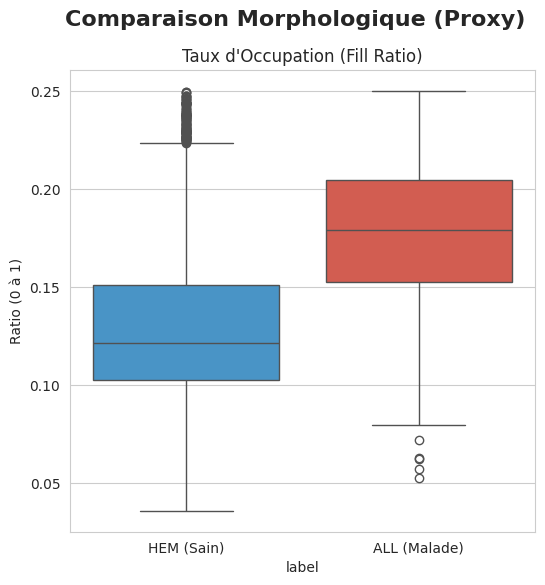

--- Médianes ---
              cell_area  fill_ratio
label                              
ALL (Malade)    36319.5    0.179356
HEM (Sain)      24644.0    0.121699


In [46]:
def plot_morphology_comparison(df_hem, df_all):
    sns.set_style("whitegrid")

    d1 = df_hem[['cell_area', 'fill_ratio']].copy()
    d1['label'] = 'HEM (Sain)'

    d2 = df_all[['cell_area', 'fill_ratio']].copy()
    d2['label'] = 'ALL (Malade)'

    combined = pd.concat([d1, d2])

    fig = plt.figure(figsize=(6, 6))

    sns.boxplot(data=combined, x='label', y='fill_ratio', palette={'HEM (Sain)': '#3498db', 'ALL (Malade)': '#e74c3c'})
    plt.title("Taux d'Occupation (Fill Ratio)")
    plt.ylabel("Ratio (0 à 1)")
    plt.suptitle("Comparaison Morphologique (Proxy)", fontsize=16, fontweight='bold')
    plt.show()

    print("--- Médianes ---")
    print(combined.groupby('label')[['cell_area', 'fill_ratio']].median())

plot_morphology_comparison(df_hem, df_all)